In [54]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
pc_train_df = pd.read_csv('power_consumption_train.csv')
pc_test_df = pd.read_csv('power_consumption_test.csv')

pc_train_df.insert(0, 'Date_Time', pd.to_datetime(pc_train_df['DateTime'], infer_datetime_format=True))
pc_train_df.drop(['DateTime'], axis=1, inplace=True)

pc_test_df.insert(0, 'Date_Time', pd.to_datetime(pc_test_df['DateTime'], infer_datetime_format=True))
pc_test_df.drop(['DateTime'], axis=1, inplace=True)

# Dataset Construction

In [3]:
# For this function, intermediate steps like extracting the month, day of year, hour, and minute, were used with help from the pandas documentation and some
# stack overflow. As an example: https://stackoverflow.com/questions/51063888/get-day-of-year-from-a-string-date-in-pandas-dataframe
def create_dataset(df, trivial_or_baseline=False, test=False):
    keys = []
    data = None

    if trivial_or_baseline:
        keys = df.drop(['Date_Time'], axis=1).keys().tolist()
        data = df.drop(df.columns[[0]], axis=1).to_numpy()
    else:
        df.insert(1, 'Month', df['Date_Time'].dt.month)
        df.insert(2, 'Day of Year', df['Date_Time'].dt.dayofyear)
        df.insert(3, 'Hour', df['Date_Time'].dt.hour)
        df.insert(4, 'Minute', df['Date_Time'].dt.minute)

        keys = df.drop(['Date_Time'], axis=1).keys().tolist()
        data = df.drop(['Date_Time'], axis=1).to_numpy()
    
    if test:
        return data
    else:
        X_keys = keys[:-3]
        y_keys = keys[-3:]
        return data, X_keys, y_keys

# Feature Selection

In [4]:
base_train_data, X_keys, y_keys = create_dataset(pc_train_df, True)
base_test_data = create_dataset(pc_test_df, True, True)

X_train_base = base_train_data[:, :-3]
y_trains_base = base_train_data[:, -3:]

X_test_base = base_test_data[:, :-3]
y_tests_base = base_test_data[:, -3:]

print(f'The base training and testing datasets that we will be using to evaluate the trivial and baseline systems contain the following features:\n{X_keys}')

The base training and testing datasets that we will be using to evaluate the trivial and baseline systems contain the following features:
['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows']


In [5]:
train_data1, X_keys, y_keys = create_dataset(pc_train_df)
test_data1 = create_dataset(pc_test_df, test=True)
print(f'The actual training and testing datasets that we will be using to evaluate the actual systems contain the following features:\n{X_keys}')

The actual training and testing datasets that we will be using to evaluate the actual systems contain the following features:
['Month', 'Day of Year', 'Hour', 'Minute', 'Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows']


In [6]:
# This function took inspiration from a towards data science article: https://towardsdatascience.com/statistics-in-python-collinearity-and-multicollinearity-4cc4dcd82b3f
# I coded everything by myself, but took inspiration from the information given in the article
def get_uncorrelated_features(X, keys, removed_indices, vifs, count):
    if np.any(np.greater_equal(vifs, 5)):
        new_X = np.copy(X)
        new_vifs = np.copy(vifs)
        new_keys = keys
        if count != 0:
            loc = np.where(np.any(np.greater_equal(vifs, 5)))[0][0]
            removed_indices.append(loc)
            print(f'Removed {keys[loc]} key which has vif: {vifs[loc]}.')
            new_X = np.delete(X, loc, axis=1)
            new_vifs = np.delete(vifs, loc)
            keys.pop(loc)
            new_keys = keys
        for i, (key, feat) in enumerate(zip(new_keys, new_X.T)):
            r2 = LinearRegression().fit(np.delete(new_X.T, i, axis=0).T, feat).score(np.delete(new_X.T, i, axis=0).T, feat)
            new_vifs[i] = 1/(1-r2)

        count += 1
        return get_uncorrelated_features(new_X, new_keys, removed_indices, new_vifs, count)
    else:
        for key, vif in zip(keys, vifs):
            print(f'The final VIF value for the {key} feature with respect to the other features is: {vif}')
        return X, vifs, keys, removed_indices

vifs = np.ones((len(X_keys),))*100
indices = []
X_train = train_data1[:, :-3]
y_train = train_data1[:, -3:]
X_train, vifs_train, X_keys, removed_indices = get_uncorrelated_features(X_train, X_keys, indices, vifs, 0)
new_train_data = np.hstack((X_train, y_train))
new_test_data = np.delete(test_data1, removed_indices, axis=1)
assert new_train_data.shape[1] == new_test_data.shape[1]

Removed Month key which has vif: 150.1102759217152.
The final VIF value for the Day of Year feature with respect to the other features is: 1.1558649040869302
The final VIF value for the Hour feature with respect to the other features is: 1.089928104878528
The final VIF value for the Minute feature with respect to the other features is: 1.000004246359987
The final VIF value for the Temperature feature with respect to the other features is: 2.0244832346160266
The final VIF value for the Humidity feature with respect to the other features is: 1.4607131943625393
The final VIF value for the Wind Speed feature with respect to the other features is: 1.3323271615874501
The final VIF value for the general diffuse flows feature with respect to the other features is: 1.952082420641154
The final VIF value for the diffuse flows feature with respect to the other features is: 1.5184171566086342


In [7]:
for i, y_train in enumerate(y_train.T):
    f_stat, p_val = f_regression(X_train, y_train)
    print(f'##### Zone {i+1} #####')
    for f, p, key in zip(f_stat, p_val, X_keys):
        print(f'For the {key} feature, the f statistic is: {f} and the p value is: {p} for Zone {i+1}')

    print()

##### Zone 1 #####
For the Day of Year feature, the f statistic is: 0.9214519880361505 and the p value is: 0.3370995550350214 for Zone 1
For the Hour feature, the f statistic is: 47751.61413416698 and the p value is: 0.0 for Zone 1
For the Minute feature, the f statistic is: 0.006114029582718843 and the p value is: 0.9376754918748649 for Zone 1
For the Temperature feature, the f statistic is: 9590.300334020347 and the p value is: 0.0 for Zone 1
For the Humidity feature, the f statistic is: 3682.467527115822 and the p value is: 0.0 for Zone 1
For the Wind Speed feature, the f statistic is: 1249.405166908106 and the p value is: 1.0492498089750947e-269 for Zone 1
For the general diffuse flows feature, the f statistic is: 1464.8388688170398 and the p value is: 4.7222094e-315 for Zone 1
For the diffuse flows feature, the f statistic is: 287.8697696353316 and the p value is: 2.376568653648145e-64 for Zone 1

##### Zone 2 #####
For the Day of Year feature, the f statistic is: 4792.52272470464

In [8]:
def scale_data(data, scaler_type='minmax', test=False, train_scaler=None):
    if test:
        scaled_data = train_scaler.transform(data)
        X_test = scaled_data[:, :-3]
        y_test1 = scaled_data[:, -3:][:, 0]
        y_test2 = scaled_data[:, -3:][:, 1]
        y_test3 = scaled_data[:, -3:][:, 2]

        return X_test, [y_test1, y_test2, y_test3]
    else:
        scaler = None
        X_train = None
        y_train1 = None
        y_train2 = None
        y_train3 = None

        if scaler_type == 'minmax':
            scaler = MinMaxScaler()
        elif scaler_type == 'standard':
            scaler = StandardScaler()
        else:
            raise Exception('Unsupported data scaler.')
        
        scaler.fit(data)
        scaled_data = scaler.transform(data)

        X_train = scaled_data[:, :-3]
        y_train1 = scaled_data[:, -3:][:, 0]
        y_train2 = scaled_data[:, -3:][:, 1]
        y_train3 = scaled_data[:, -3:][:, 2]

        return X_train, [y_train1, y_train2, y_train3], scaler

In [9]:
X_train, y_trains, scaler = scale_data(new_train_data)
X_test, y_tests = scale_data(new_test_data, test=True, train_scaler=scaler)
print(f'The final, scaled training and testing datasets that we will be using to evaluate the actual systems contain the following features:\n{X_keys}')

The final, scaled training and testing datasets that we will be using to evaluate the actual systems contain the following features:
['Day of Year', 'Hour', 'Minute', 'Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows']


# Trivial and Baseline System Performances for Each Zone

During the training phase, the trivial system results in an r-squared value of: 0.0 and an RMSE value of: 7093.917888544014 for Zone 1
During the testing phase, the trivial system results in an r-squared value of: -7.218569957156973e-05 and an RMSE value of: 7274.525217068762 for Zone 1
During the training phase, the the baseline system results in an r-squared value of: 0.19942471095283587 and an RMSE value of: 6347.27401836951 for Zone 1
During the testing phase, the the baseline system results in an r-squared value of: 0.2359124148660755 and an RMSE value of: 6358.586021956999 for Zone 1


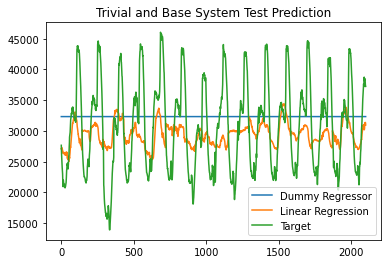

During the training phase, the trivial system results in an r-squared value of: 0.0 and an RMSE value of: 5173.879558851318 for Zone 2
During the testing phase, the trivial system results in an r-squared value of: -0.0017100099270774827 and an RMSE value of: 5310.675983813227 for Zone 2
During the training phase, the the baseline system results in an r-squared value of: 0.1673978072281569 and an RMSE value of: 4721.011842587546 for Zone 2
During the testing phase, the the baseline system results in an r-squared value of: 0.1808546118359058 and an RMSE value of: 4802.410649210068 for Zone 2


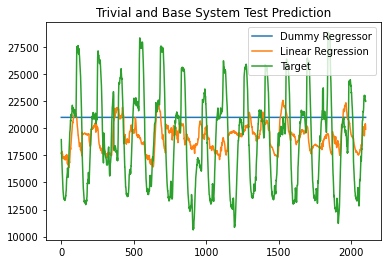

During the training phase, the trivial system results in an r-squared value of: 0.0 and an RMSE value of: 6552.5935093522285 for Zone 3
During the testing phase, the trivial system results in an r-squared value of: -0.0008538751177218362 and an RMSE value of: 6892.809840500937 for Zone 3
During the training phase, the the baseline system results in an r-squared value of: 0.27578279160806884 and an RMSE value of: 5576.319477404408 for Zone 3
During the testing phase, the the baseline system results in an r-squared value of: 0.2983679255881373 and an RMSE value of: 5771.194045260378 for Zone 3


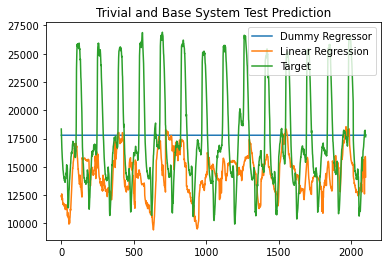

In [66]:
for i, (y_train, y_test) in enumerate(zip(y_trains_base.T, y_tests_base.T)):
    dummy = DummyRegressor().fit(X_train_base, y_train)
    r_squared_dummy_train = dummy.score(X_train_base, y_train)
    dummy_rmse_train = np.sqrt(mean_squared_error(y_train, dummy.predict(X_train_base)))

    r_squared_dummy_test = dummy.score(X_test_base, y_test)
    dummy_rmse_test = np.sqrt(mean_squared_error(y_test, dummy.predict(X_test_base)))

    print(f'During the training phase, the trivial system results in an r-squared value of: {r_squared_dummy_train} and an RMSE value of: {dummy_rmse_train} for Zone {i+1}')
    print(f'During the testing phase, the trivial system results in an r-squared value of: {r_squared_dummy_test} and an RMSE value of: {dummy_rmse_test} for Zone {i+1}')

    linreg_base = LinearRegression().fit(X_train_base, y_train)
    r_squared_linreg_base_train = linreg_base.score(X_train_base, y_train)
    linreg_base_rmse_train = np.sqrt(mean_squared_error(y_train, linreg_base.predict(X_train_base)))

    r_squared_linreg_base_test = linreg_base.score(X_test_base, y_test)
    linreg_base_rmse_test = np.sqrt(mean_squared_error(y_test, linreg_base.predict(X_test_base)))

    print(f'During the training phase, the the baseline system results in an r-squared value of: {r_squared_linreg_base_train} and an RMSE value of: {linreg_base_rmse_train} for Zone {i+1}')
    print(f'During the testing phase, the the baseline system results in an r-squared value of: {r_squared_linreg_base_test} and an RMSE value of: {linreg_base_rmse_test} for Zone {i+1}')

    plt.plot(range(int(np.size(y_test)/5)), dummy.predict(X_test_base)[:int(np.size(y_test)/5)])
    plt.plot(range(int(np.size(y_test)/5)), linreg_base.predict(X_test_base)[:int(np.size(y_test)/5)])
    plt.plot(range(int(np.size(y_test)/5)), y_test[:int(np.size(y_test)/5)])
    plt.legend(['Dummy Regressor', 'Linear Regression', 'Target'])
    plt.title('Trivial and Base System Test Prediction')
    plt.show()

# Linear Regression System

In [11]:
def get_unscaled_rmse(y_pred, scaler, zone, test=False):
    if not test:
        y_true = new_train_data[:, -3:][:, zone]
        scaled_data = np.hstack((X_train, y_trains[0][:, np.newaxis], y_trains[1][:, np.newaxis], y_trains[2][:, np.newaxis]))
        scaled_data[:, -3:][:, zone] = y_pred
        descaled_data = scaler.inverse_transform(scaled_data)
        y_pred_unscaled = descaled_data[:, -3:][:, zone]
        return np.sqrt(mean_squared_error(y_true, y_pred_unscaled))
    else:
        y_true = new_test_data[:, -3:][:, zone]
        scaled_data = np.hstack((X_test, y_tests[0][:, np.newaxis], y_tests[1][:, np.newaxis], y_tests[2][:, np.newaxis]))
        scaled_data[:, -3:][:, zone] = y_pred
        descaled_data = scaler.inverse_transform(scaled_data)
        y_pred_unscaled = descaled_data[:, -3:][:, zone]
        return np.sqrt(mean_squared_error(y_true, y_pred_unscaled)), y_true, y_pred_unscaled

The Linear Regression system results in an r-squared value of: 0.635203322024698 and an RMSE value of: 4284.612935581565 for Zone 1 during the training phase
The Linear Regression system results in an r-squared value of: 0.6540850006565264 and an RMSE value of: 4278.3240540481 for Zone 1 during the testing phase


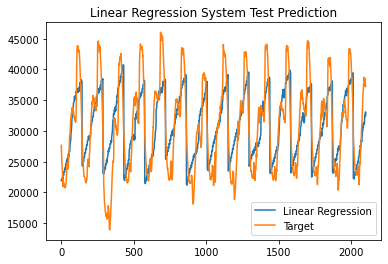

The Linear Regression system results in an r-squared value of: 0.5766102670425506 and an RMSE value of: 3366.5609056969743 for Zone 2 during the training phase
The Linear Regression system results in an r-squared value of: 0.5912347936880349 and an RMSE value of: 3392.4679947756213 for Zone 2 during the testing phase


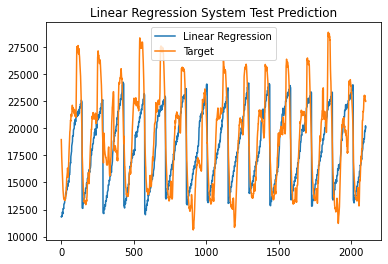

The Linear Regression system results in an r-squared value of: 0.607397133966196 and an RMSE value of: 4105.725973851494 for Zone 3 during the training phase
The Linear Regression system results in an r-squared value of: 0.5806169498936864 and an RMSE value of: 4461.864699990801 for Zone 3 during the testing phase


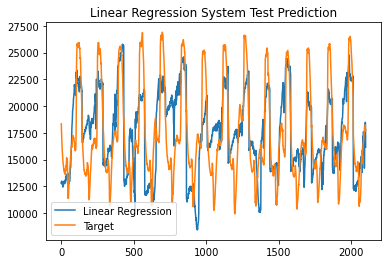

In [12]:
for i, (y_train, y_test) in enumerate(zip(y_trains, y_tests)):
    linreg = LinearRegression().fit(X_train, y_train)
    r_squared_linreg_train = linreg.score(X_train, y_train)
    unscaled_linreg_train_rmse = get_unscaled_rmse(linreg.predict(X_train), scaler, i)

    r_squared_linreg_test = linreg.score(X_test, y_test)
    unscaled_ridge_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(linreg.predict(X_test), scaler, i, test=True)

    print(f'The Linear Regression system results in an r-squared value of: {r_squared_linreg_train} and an RMSE value of: {unscaled_linreg_train_rmse} for Zone {i+1} during the training phase')
    print(f'The Linear Regression system results in an r-squared value of: {r_squared_linreg_test} and an RMSE value of: {unscaled_ridge_test_rmse} for Zone {i+1} during the testing phase')

    plt.plot(range(int(np.size(y_true_test)/5)), y_pred_unscaled[:int(np.size(y_true_test)/5)])
    plt.plot(range(int(np.size(y_true_test)/5)), y_true_test[:int(np.size(y_true_test)/5)])
    plt.legend(['Linear Regression', 'Target'])
    plt.title('Linear Regression System Test Prediction')
    plt.show()

# Ridge Regression System

## Baseline accuracy on train and test sets

The Ridge Regression system results in an r-squared value of: 0.6352030451757696 and an RMSE value of: 4284.6145614054085 for Zone 1 during the training phase
The Ridge Regression system results in an r-squared value of: 0.6540419950671805 and an RMSE value of: 4278.589995290029 for Zone 1 during the testing phase


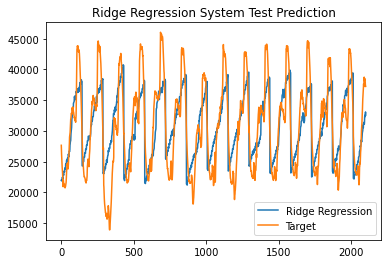

The Ridge Regression system results in an r-squared value of: 0.576610213786868 and an RMSE value of: 3366.561117426829 for Zone 2 during the training phase
The Ridge Regression system results in an r-squared value of: 0.5912108700925733 and an RMSE value of: 3392.5672679564127 for Zone 2 during the testing phase


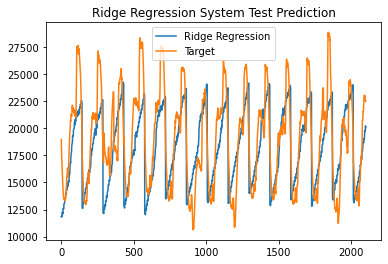

The Ridge Regression system results in an r-squared value of: 0.6073962216503307 and an RMSE value of: 4105.730744214999 for Zone 3 during the training phase
The Ridge Regression system results in an r-squared value of: 0.58056538895706 and an RMSE value of: 4462.138972940441 for Zone 3 during the testing phase


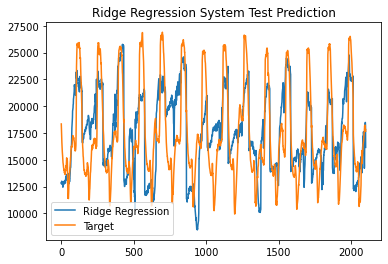

In [39]:
for i, (y_train, y_test) in enumerate(zip(y_trains, y_tests)):
    ridge = Ridge().fit(X_train, y_train)
    r_squared_ridge_train = ridge.score(X_train, y_train)
    unscaled_ridge_train_rmse = get_unscaled_rmse(ridge.predict(X_train), scaler, i)

    r_squared_ridge_test = ridge.score(X_test, y_test)
    unscaled_ridge_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(ridge.predict(X_test), scaler, i, test=True)

    print(f'The Ridge Regression system results in an r-squared value of: {r_squared_ridge_train} and an RMSE value of: {unscaled_ridge_train_rmse} for Zone {i+1} during the training phase')
    print(f'The Ridge Regression system results in an r-squared value of: {r_squared_ridge_test} and an RMSE value of: {unscaled_ridge_test_rmse} for Zone {i+1} during the testing phase')

    plt.plot(range(int(np.size(y_true_test)/5)), y_pred_unscaled[:int(np.size(y_true_test)/5)])
    plt.plot(range(int(np.size(y_true_test)/5)), y_true_test[:int(np.size(y_true_test)/5)])
    plt.legend(['Ridge Regression', 'Target'])
    plt.title('Ridge Regression System Test Prediction')
    plt.show()

## Hyperparameter Tuning

In [40]:
param_grid = {}
param_grid["solver"] = ["svd", "cholesky", "lsqr", "lbfgs"]
param_grid["alpha"] = [0.001, 0.005, 0.1, 0.5, 0.75, 1, 10]
best_models_ridge = []

for i, y_train in enumerate(y_trains):
    ridge = Ridge()
    cv = KFold(n_splits=5, shuffle=True)
    
    gscv = GridSearchCV(ridge, param_grid, n_jobs=-1, cv=cv)
    gscv.fit(X_train, y_train)
    best_models_ridge.append(gscv.best_estimator_)

    print(f'Best Score: {gscv.best_score_}')
    print(f'Best Hyperparameters: {gscv.best_params_}')

Best Score: 0.6350314089931917
Best Hyperparameters: {'alpha': 0.5, 'solver': 'svd'}
Best Score: 0.5763169508028037
Best Hyperparameters: {'alpha': 1, 'solver': 'svd'}
Best Score: 0.6071100647660607
Best Hyperparameters: {'alpha': 0.1, 'solver': 'lsqr'}


## Final Performance

The best Ridge Regression system results in an r-squared value of: 0.6352032526806417 and an RMSE value of: 4284.613342811735 for Zone 1 during the training phase
The best Ridge Regression system results in an r-squared value of: 0.6540635481727012 and an RMSE value of: 4278.456715619302 for Zone 1 during the testing phase


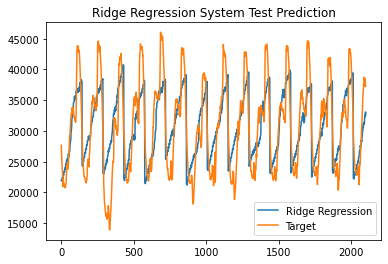

The best Ridge Regression system results in an r-squared value of: 0.576610213786868 and an RMSE value of: 3366.561117426829 for Zone 2 during the training phase
The best Ridge Regression system results in an r-squared value of: 0.5912108700925736 and an RMSE value of: 3392.567267956412 for Zone 2 during the testing phase


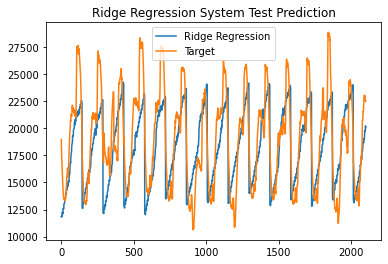

The best Ridge Regression system results in an r-squared value of: 0.6073971248090702 and an RMSE value of: 4105.726021732766 for Zone 3 during the training phase
The best Ridge Regression system results in an r-squared value of: 0.5806118638281004 and an RMSE value of: 4461.891755528323 for Zone 3 during the testing phase


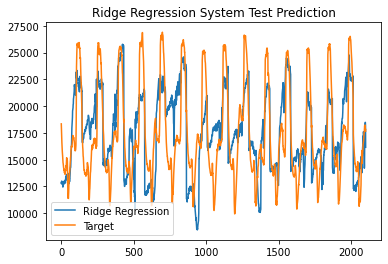

In [41]:
for i, (estimator, y_train, y_test) in enumerate(zip(best_models_ridge, y_trains, y_tests)):
    model_params = estimator.get_params()
    model = Ridge(alpha=model_params['alpha'], solver=model_params['solver'])
    model.fit(X_train, y_train)
    
    r_squared_best_ridge_train = model.score(X_train, y_train)
    unscaled_best_ridge_train_rmse = get_unscaled_rmse(model.predict(X_train), scaler, i)
    r_squared_best_ridge_test = model.score(X_test, y_test)
    unscaled_best_ridge_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(model.predict(X_test), scaler, i, test=True)

    print(f'The best Ridge Regression system results in an r-squared value of: {r_squared_best_ridge_train} and an RMSE value of: {unscaled_best_ridge_train_rmse} for Zone {i+1} during the training phase')
    print(f'The best Ridge Regression system results in an r-squared value of: {r_squared_best_ridge_test} and an RMSE value of: {unscaled_best_ridge_test_rmse} for Zone {i+1} during the testing phase')

    plt.plot(range(int(np.size(y_true_test)/5)), y_pred_unscaled[:int(np.size(y_true_test)/5)])
    plt.plot(range(int(np.size(y_true_test)/5)), y_true_test[:int(np.size(y_true_test)/5)])
    plt.legend(['Ridge Regression', 'Target'])
    plt.title('Ridge Regression System Test Prediction')
    plt.show()

# Support Vector Regression System

## Baseline Accuracy on Train and Test Sets

The SVR system results in an r-squared value of 0.8705340106856612 and an RMSE value of: 2552.4897361521166 for Zone 1 during the training phase
The SVR system results in an r-squared value of 0.863715786853866 and an RMSE value of: 2685.4171297251078 for Zone 1 during the testing phase


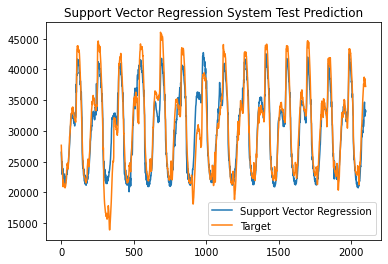

The SVR system results in an r-squared value of 0.8274242006312508 and an RMSE value of: 2149.3456439091315 for Zone 2 during the training phase
The SVR system results in an r-squared value of 0.8064463011148578 and an RMSE value of: 2334.4229048375373 for Zone 2 during the testing phase


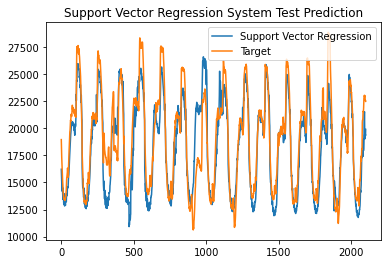

The SVR system results in an r-squared value of 0.8620317516857661 and an RMSE value of: 2433.9004023912494 for Zone 3 during the training phase
The SVR system results in an r-squared value of 0.8333361989219478 and an RMSE value of: 2812.7530289914616 for Zone 3 during the testing phase


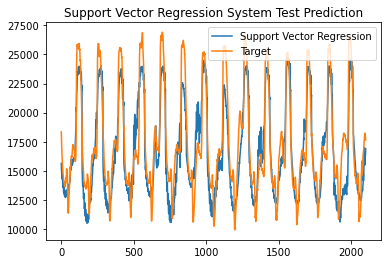

In [42]:
for i, (y_train, y_test) in enumerate(zip(y_trains, y_tests)):
    svr = SVR().fit(X_train, y_train)
    r_squared_svm_train = svr.score(X_train, y_train)
    unscaled_svr_train_rmse = get_unscaled_rmse(svr.predict(X_train), scaler, i)

    r_squared_svm_test = svr.score(X_test, y_test)
    unscaled_svr_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(svr.predict(X_test), scaler, i, test=True)

    print(f'The SVR system results in an r-squared value of {r_squared_svm_train} and an RMSE value of: {unscaled_svr_train_rmse} for Zone {i+1} during the training phase')
    print(f'The SVR system results in an r-squared value of {r_squared_svm_test} and an RMSE value of: {unscaled_svr_test_rmse} for Zone {i+1} during the testing phase')

    plt.plot(range(int(np.size(y_true_test)/5)), y_pred_unscaled[:int(np.size(y_true_test)/5)])
    plt.plot(range(int(np.size(y_true_test)/5)), y_true_test[:int(np.size(y_true_test)/5)])
    plt.legend(['Support Vector Regression', 'Target'])
    plt.title('Support Vector Regression System Test Prediction')
    plt.show()

## Hyperparameter Tuning

In [43]:
param_grid = {}
param_grid["kernel"] = ["linear", "poly", "rbf"]
best_models_svr = []

for i, (y_train, y_test) in enumerate(zip(y_trains, y_tests)):
    svr = SVR()
    cv = KFold(n_splits=5, shuffle=True)
    
    gscv = GridSearchCV(svr, param_grid, n_jobs=-1, cv=cv)
    gscv.fit(X_train, y_train)
    best_models_svr.append(gscv.best_estimator_)

    print(f'Best Score: {gscv.best_score_}')
    print(f'Best Hyperparameters: {gscv.best_params_}')

Best Score: 0.8669403725589794
Best Hyperparameters: {'kernel': 'rbf'}
Best Score: 0.8225292725744493
Best Hyperparameters: {'kernel': 'rbf'}
Best Score: 0.8574035596600333
Best Hyperparameters: {'kernel': 'rbf'}


In [44]:
for i, (estimator, y_train, y_test) in enumerate(zip(best_models_svr, y_trains, y_tests)):
    model_params = estimator.get_params()
    model = SVR(kernel=model_params['kernel'])
    model.fit(X_train, y_train)

    r_squared_best_svr_train = model.score(X_train, y_train)
    unscaled_svr_train_rmse = get_unscaled_rmse(model.predict(X_train), scaler, i)
    r_squared_best_svr_test = model.score(X_test, y_test)
    unscaled_svr_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(model.predict(X_test), scaler, i, test=True)
    
    print(f'The best SVR system results in an r-squared value of: {r_squared_best_svr_train} and an RMSE value of: {unscaled_svr_train_rmse} for Zone {i+1} during the training phase')
    print(f'The best SVR system results in an r-squared value of: {r_squared_best_svr_test} and an RMSE value of: {unscaled_svr_test_rmse} for Zone {i+1} during the testing phase')

The best SVR system results in an r-squared value of: 0.8705340106856612 and an RMSE value of: 2552.4897361521166 for Zone 1 during the training phase
The best SVR system results in an r-squared value of: 0.863715786853866 and an RMSE value of: 2685.4171297251078 for Zone 1 during the testing phase
The best SVR system results in an r-squared value of: 0.8274242006312508 and an RMSE value of: 2149.3456439091315 for Zone 2 during the training phase
The best SVR system results in an r-squared value of: 0.8064463011148578 and an RMSE value of: 2334.4229048375373 for Zone 2 during the testing phase
The best SVR system results in an r-squared value of: 0.8620317516857661 and an RMSE value of: 2433.9004023912494 for Zone 3 during the training phase
The best SVR system results in an r-squared value of: 0.8333361989219478 and an RMSE value of: 2812.7530289914616 for Zone 3 during the testing phase


In [47]:
param_grid_svr = {}
param_grid_svr["C"] = [0.1, 1, 10, 100]
param_grid_svr["gamma"] = [1e-4, 1e-3, 1e-2, 0.1, 1]

for i, (model, y_train) in enumerate(zip(best_models_svr, y_trains)):
    cv = KFold(n_splits=5, shuffle=True)
    gscv = GridSearchCV(model, param_grid_svr, n_jobs=-1, cv=cv)
    gscv.fit(X_train, y_train)
    best_models_svr[i].C = gscv.best_estimator_.C
    best_models_svr[i].gamma = gscv.best_estimator_.gamma

    print(f'Best Score: {gscv.best_score_}')
    print(f'Best Hyperparameters: {gscv.best_params_}')

Best Score: 0.8916428979469628
Best Hyperparameters: {'C': 100, 'gamma': 1}
Best Score: 0.8482213037461646
Best Hyperparameters: {'C': 100, 'gamma': 1}
Best Score: 0.8856496753420743
Best Hyperparameters: {'C': 100, 'gamma': 1}


## Final Model Performance

The best SVR system results in an r-squared value of: 0.897211560307809 and an RMSE value of: 2274.3552103046395 for Zone 1 during the training phase
The best SVR system results in an r-squared value of: 0.8811097380381518 and an RMSE value of: 2508.199756342632 for Zone 1 during the testing phase


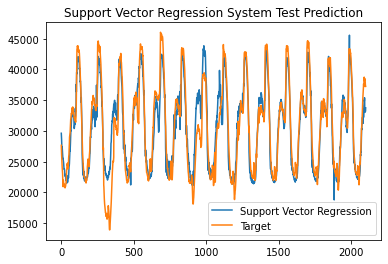

The best SVR system results in an r-squared value of: 0.8556352217251681 and an RMSE value of: 1965.8344375244292 for Zone 2 during the training phase
The best SVR system results in an r-squared value of: 0.8363020101313619 and an RMSE value of: 2146.8439196138797 for Zone 2 during the testing phase


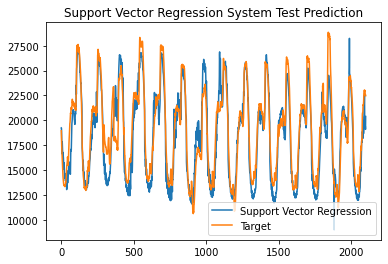

The best SVR system results in an r-squared value of: 0.8896945435679537 and an RMSE value of: 2176.2647383470785 for Zone 3 during the training phase
The best SVR system results in an r-squared value of: 0.8608763508955621 and an RMSE value of: 2569.87168877458 for Zone 3 during the testing phase


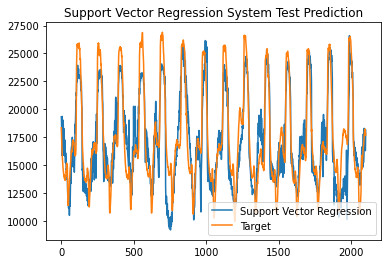

In [48]:
for i, (estimator, y_train, y_test) in enumerate(zip(best_models_svr, y_trains, y_tests)):
    model_params = estimator.get_params()
    model = SVR(kernel=model_params['kernel'], C=model_params['C'], gamma=model_params['gamma'])
    model.fit(X_train, y_train)
    
    r_squared_best_svr_train = model.score(X_train, y_train)
    unscaled_best_svr_train_rmse = get_unscaled_rmse(model.predict(X_train), scaler, i)
    r_squared_best_svr_test = model.score(X_test, y_test)
    unscaled_best_svr_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(model.predict(X_test), scaler, i, test=True)
    
    print(f'The best SVR system results in an r-squared value of: {r_squared_best_svr_train} and an RMSE value of: {unscaled_best_svr_train_rmse} for Zone {i+1} during the training phase')
    print(f'The best SVR system results in an r-squared value of: {r_squared_best_svr_test} and an RMSE value of: {unscaled_best_svr_test_rmse} for Zone {i+1} during the testing phase')

    plt.plot(range(int(np.size(y_true_test)/5)), y_pred_unscaled[:int(np.size(y_true_test)/5)])
    plt.plot(range(int(np.size(y_true_test)/5)), y_true_test[:int(np.size(y_true_test)/5)])
    plt.legend(['Support Vector Regression', 'Target'])
    plt.title('Support Vector Regression System Test Prediction')
    plt.show()

# MLP System

## Baseline Accuracy on Train and Test Sets

The MLP system results in an r-squared value of 0.8844753266817019 and an RMSE value of: 2411.1461286158074 for Zone 1 during the training phase
The MLP system results in an r-squared value of 0.876608233565394 and an RMSE value of: 2555.2421930603514 for Zone 1 during the testing phase


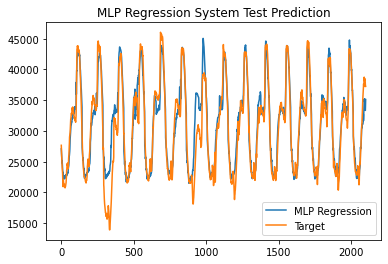

The MLP system results in an r-squared value of 0.8407532320203751 and an RMSE value of: 2064.674662023879 for Zone 2 during the training phase
The MLP system results in an r-squared value of 0.8300906363938971 and an RMSE value of: 2187.1947499326902 for Zone 2 during the testing phase


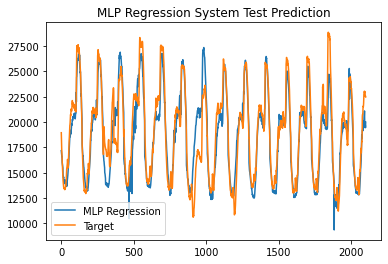

The MLP system results in an r-squared value of 0.9040392992742565 and an RMSE value of: 2029.8312418808077 for Zone 3 during the training phase
The MLP system results in an r-squared value of 0.8727007667888622 and an RMSE value of: 2458.2375801294243 for Zone 3 during the testing phase


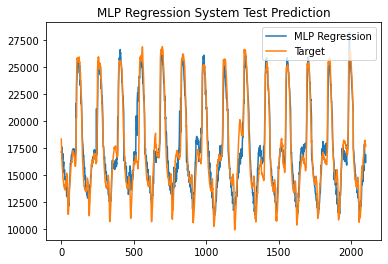

In [37]:
for i, (y_train, y_test) in enumerate(zip(y_trains, y_tests)):
    mlp = MLPRegressor().fit(X_train, y_train)
    r_squared_mlp_train = mlp.score(X_train, y_train)
    unscaled_mlp_train_rmse = get_unscaled_rmse(mlp.predict(X_train), scaler, i)

    r_squared_mlp_test = mlp.score(X_test, y_test)
    unscaled_mlp_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(mlp.predict(X_test), scaler, i, test=True)

    print(f'The MLP system results in an r-squared value of {r_squared_mlp_train} and an RMSE value of: {unscaled_mlp_train_rmse} for Zone {i+1} during the training phase')
    print(f'The MLP system results in an r-squared value of {r_squared_mlp_test} and an RMSE value of: {unscaled_mlp_test_rmse} for Zone {i+1} during the testing phase')

    plt.plot(range(int(np.size(y_true_test)/5)), y_pred_unscaled[:int(np.size(y_true_test)/5)])
    plt.plot(range(int(np.size(y_true_test)/5)), y_true_test[:int(np.size(y_true_test)/5)])
    plt.legend(['MLP Regression', 'Target'])
    plt.title('MLP Regression System Test Prediction')
    plt.show()

## Hyperparameter Tuning

In [17]:
param_grid1 = {}
param_grid1["solver"] = ["sgd", "adam"]
param_grid1["momentum"] = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9]
param_grid1["nesterovs_momentum"] = [True, False]
param_grid1["learning_rate"] = ["constant", "invscaling", "adaptive"]
param_grid1["learning_rate_init"] = [1e-4, 1e-3, 1e-2, 1e-1]
best_models_mlp = []

for i, y_train in enumerate(y_trains):
    mlp = MLPRegressor()
    cv = KFold(n_splits=5, shuffle=True)

    gscv = GridSearchCV(mlp, param_grid1, n_jobs=-1, cv=cv)
    gscv.fit(X_train, y_train)
    best_models_mlp.append(gscv.best_estimator_)

    print(f'Best Score: {gscv.best_score_}')
    print(f'Best Hyperparameters: {gscv.best_params_}')

Best Score: 0.8977091344225071
Best Hyperparameters: {'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'momentum': 0.8, 'nesterovs_momentum': False, 'solver': 'adam'}
Best Score: 0.8508020613421984
Best Hyperparameters: {'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'momentum': 0.9, 'nesterovs_momentum': True, 'solver': 'adam'}
Best Score: 0.9282278559386155
Best Hyperparameters: {'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'momentum': 0.7, 'nesterovs_momentum': True, 'solver': 'adam'}


In [38]:
for i, (estimator, y_train, y_test) in enumerate(zip(best_models_mlp, y_trains, y_tests)):
    model_params = estimator.get_params()
    model = MLPRegressor(solver=model_params['solver'], momentum=model_params['momentum'], nesterovs_momentum=model_params['nesterovs_momentum'],
                            learning_rate=model_params['learning_rate'], learning_rate_init=model_params['learning_rate_init'])
    model.fit(X_train, y_train)

    r_squared_best_mlp_train = model.score(X_train, y_train)
    unscaled_mlp_train_rmse = get_unscaled_rmse(model.predict(X_train), scaler, i)
    r_squared_best_mlp_test = model.score(X_test, y_test)
    unscaled_mlp_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(model.predict(X_test), scaler, i, test=True)
    
    print(f'The best MLP Regression system results in an r-squared value of: {r_squared_best_mlp_train} and an RMSE value of: {unscaled_mlp_train_rmse} for Zone {i+1} during the training phase')
    print(f'The best MLP Regression system results in an r-squared value of: {r_squared_best_mlp_test} and an RMSE value of: {unscaled_mlp_test_rmse} for Zone {i+1} during the testing phase')

The best MLP Regression system results in an r-squared value of: 0.8983681594667596 and an RMSE value of: 2261.523227180097 for Zone 1 during the training phase
The best MLP Regression system results in an r-squared value of: 0.8959634967007097 and an RMSE value of: 2346.290881703614 for Zone 1 during the testing phase
The best MLP Regression system results in an r-squared value of: 0.8299915495295919 and an RMSE value of: 2133.2982112466516 for Zone 2 during the training phase
The best MLP Regression system results in an r-squared value of: 0.816382282125047 and an RMSE value of: 2273.715334730852 for Zone 2 during the testing phase
The best MLP Regression system results in an r-squared value of: 0.9292788764969717 and an RMSE value of: 1742.5602500363364 for Zone 3 during the training phase
The best MLP Regression system results in an r-squared value of: 0.9236536330838409 and an RMSE value of: 1903.729095134268 for Zone 3 during the testing phase


In [20]:
param_grid2 = {}
param_grid2["hidden_layer_sizes"] = [(50,), (100,), (200,), (400,), (50, 25,), (100, 50,), (200, 100,), (400, 200,),
                                        (50, 25, 10,), (100, 50, 25,), (200, 100, 50,), (400, 200, 100,)]

for i, (model, y_train) in enumerate(zip(best_models_mlp, y_trains)):
    cv = KFold(n_splits=5, shuffle=True)
    gscv = GridSearchCV(model, param_grid2, n_jobs=-1, cv=cv)
    gscv.fit(X_train, y_train)
    best_models_mlp[i].hidden_layer_sizes = gscv.best_estimator_.hidden_layer_sizes

    print(f'Best Score: {gscv.best_score_}')
    print(f'Best Hyperparameters: {gscv.best_params_}')

Best Score: 0.929028935193075
Best Hyperparameters: {'hidden_layer_sizes': (400, 200, 100)}
Best Score: 0.8892825487515188
Best Hyperparameters: {'hidden_layer_sizes': (400, 200, 100)}
Best Score: 0.9603653688252634
Best Hyperparameters: {'hidden_layer_sizes': (200, 100, 50)}


In [23]:
for i, (estimator, y_train, y_test) in enumerate(zip(best_models_mlp, y_trains, y_tests)):
    model_params = estimator.get_params()
    model = MLPRegressor(solver=model_params['solver'], momentum=model_params['momentum'], nesterovs_momentum=model_params['nesterovs_momentum'],
                            learning_rate=model_params['learning_rate'], learning_rate_init=model_params['learning_rate_init'],
                            hidden_layer_sizes=model_params['hidden_layer_sizes'])
    model.fit(X_train, y_train)

    r_squared_best_mlp_train = model.score(X_train, y_train)
    unscaled_mlp_train_rmse = get_unscaled_rmse(model.predict(X_train), scaler, i)
    r_squared_best_mlp_test = model.score(X_test, y_test)
    unscaled_mlp_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(model.predict(X_test), scaler, i, test=True)

    print(f'The best MLP Regression system results in an r-squared value of: {r_squared_best_mlp_train} and an RMSE value of: {unscaled_mlp_train_rmse} for Zone {i+1} during the training phase')
    print(f'The best MLP Regression system results in an r-squared value of: {r_squared_best_mlp_test} and an RMSE value of: {unscaled_mlp_test_rmse} for Zone {i+1} during the testing phase')

The best MLP Regression system results in an r-squared value of: 0.9261033509310488 and an RMSE value of: 1928.406247771288 for Zone 1 during the training phase
The best MLP Regression system results in an r-squared value of: 0.9117305071764058 and an RMSE value of: 2161.1966961360504 for Zone 1 during the testing phase
The best MLP Regression system results in an r-squared value of: 0.8863687786493041 and an RMSE value of: 1744.0749806103145 for Zone 2 during the training phase
The best MLP Regression system results in an r-squared value of: 0.855962060154536 and an RMSE value of: 2013.804229648031 for Zone 2 during the testing phase
The best MLP Regression system results in an r-squared value of: 0.9419176999453023 and an RMSE value of: 1579.1927093686281 for Zone 3 during the training phase
The best MLP Regression system results in an r-squared value of: 0.9414759608809504 and an RMSE value of: 1666.779328833965 for Zone 3 during the testing phase


In [25]:
param_grid3 = {}
param_grid3["alpha"] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
param_grid3["early_stopping"] = [True, False]

for i, (model, y_train) in enumerate(zip(best_models_mlp, y_trains)):
    cv = KFold(n_splits=5, shuffle=True)
    gscv = GridSearchCV(model, param_grid3, n_jobs=-1, cv=cv)
    gscv.fit(X_train, y_train)
    best_models_mlp[i].alpha = gscv.best_estimator_.alpha
    best_models_mlp[i].early_stopping = gscv.best_estimator_.early_stopping

    print(f'Best Score: {gscv.best_score_}')
    print(f'Best Hyperparameters: {gscv.best_params_}')

Best Score: 0.9479175469012766
Best Hyperparameters: {'alpha': 1e-05, 'early_stopping': True}
Best Score: 0.9174410278933356
Best Hyperparameters: {'alpha': 1e-05, 'early_stopping': True}
Best Score: 0.9740180238589051
Best Hyperparameters: {'alpha': 0.0001, 'early_stopping': True}


In [26]:
for i, (estimator, y_train, y_test) in enumerate(zip(best_models_mlp, y_trains, y_tests)):
    model_params = estimator.get_params()
    model = MLPRegressor(solver=model_params['solver'], momentum=model_params['momentum'], nesterovs_momentum=model_params['nesterovs_momentum'],
                            learning_rate=model_params['learning_rate'], learning_rate_init=model_params['learning_rate_init'],
                            hidden_layer_sizes=model_params['hidden_layer_sizes'], alpha=model_params['alpha'], early_stopping=model_params['early_stopping'])
    model.fit(X_train, y_train)

    r_squared_best_mlp_train = model.score(X_train, y_train)
    unscaled_mlp_train_rmse = get_unscaled_rmse(model.predict(X_train), scaler, i)
    r_squared_best_mlp_test = model.score(X_test, y_test)
    unscaled_mlp_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(model.predict(X_test), scaler, i, test=True)

    print(f'The best MLP Regression system results in an r-squared value of: {r_squared_best_mlp_train} and an RMSE value of: {unscaled_mlp_train_rmse} for Zone {i+1} during the training phase')
    print(f'The best MLP Regression system results in an r-squared value of: {r_squared_best_mlp_test} and an RMSE value of: {unscaled_mlp_test_rmse} for Zone {i+1} during the testing phase')

The best MLP Regression system results in an r-squared value of: 0.9484331790554016 and an RMSE value of: 1610.9102185462903 for Zone 1 during the training phase
The best MLP Regression system results in an r-squared value of: 0.9293515146685601 and an RMSE value of: 1933.4832182470009 for Zone 1 during the testing phase
The best MLP Regression system results in an r-squared value of: 0.9259386024416545 and an RMSE value of: 1408.0311609070222 for Zone 2 during the training phase
The best MLP Regression system results in an r-squared value of: 0.895427022705809 and an RMSE value of: 1715.8864101283655 for Zone 2 during the testing phase
The best MLP Regression system results in an r-squared value of: 0.977621238941133 and an RMSE value of: 980.2373511787719 for Zone 3 during the training phase
The best MLP Regression system results in an r-squared value of: 0.9686191322739178 and an RMSE value of: 1220.5158788343308 for Zone 3 during the testing phase


In [31]:
param_grid4 = {}
param_grid4["max_iter"] = [25, 50, 100, 200]
param_grid4["batch_size"] = [50, 64, 100, 128, 200, 256]

for i, (model, y_train) in enumerate(zip(best_models_mlp, y_trains)):
    cv = KFold(n_splits=5, shuffle=True)
    gscv = GridSearchCV(model, param_grid4, n_jobs=-1, cv=cv)
    gscv.fit(X_train, y_train)
    best_models_mlp[i].max_iter = gscv.best_estimator_.max_iter
    best_models_mlp[i].batch_size = gscv.best_estimator_.batch_size

    print(f'Best Score: {gscv.best_score_}')
    print(f'Best Hyperparameters: {gscv.best_params_}')

Best Score: 0.9447071752584228
Best Hyperparameters: {'batch_size': 200, 'max_iter': 200}
Best Score: 0.9235187014782019
Best Hyperparameters: {'batch_size': 256, 'max_iter': 200}
Best Score: 0.9751203611930368
Best Hyperparameters: {'batch_size': 200, 'max_iter': 100}


In [53]:
print(best_models_mlp)

[MLPRegressor(alpha=1e-05, batch_size=200, early_stopping=True,
             hidden_layer_sizes=(400, 200, 100), learning_rate='invscaling',
             learning_rate_init=0.01, momentum=0.8, nesterovs_momentum=False), MLPRegressor(alpha=1e-05, batch_size=256, early_stopping=True,
             hidden_layer_sizes=(400, 200, 100), learning_rate='invscaling',
             learning_rate_init=0.01), MLPRegressor(batch_size=200, early_stopping=True,
             hidden_layer_sizes=(200, 100, 50), learning_rate='invscaling',
             learning_rate_init=0.01, max_iter=100, momentum=0.7)]


## Final Model Performance

The best MLP Regression system results in an r-squared value of: 0.9555423770920237 and an RMSE value of: 1495.750911442536 for Zone 1 during the training phase
The best MLP Regression system results in an r-squared value of: 0.9347766720344617 and an RMSE value of: 1857.76363126691 for Zone 1 during the testing phase


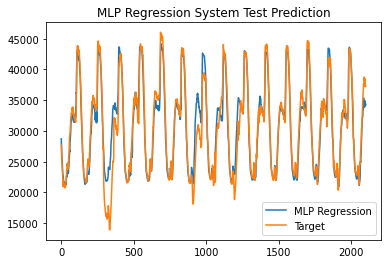

The best MLP Regression system results in an r-squared value of: 0.9283754928995046 and an RMSE value of: 1384.6727256174765 for Zone 2 during the training phase
The best MLP Regression system results in an r-squared value of: 0.8927884224360771 and an RMSE value of: 1737.3992967148865 for Zone 2 during the testing phase


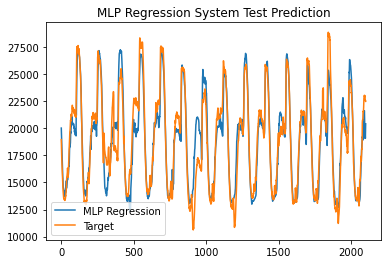

The best MLP Regression system results in an r-squared value of: 0.9691844340835107 and an RMSE value of: 1150.2660483608377 for Zone 3 during the training phase
The best MLP Regression system results in an r-squared value of: 0.9628740363076737 and an RMSE value of: 1327.5467614673873 for Zone 3 during the testing phase


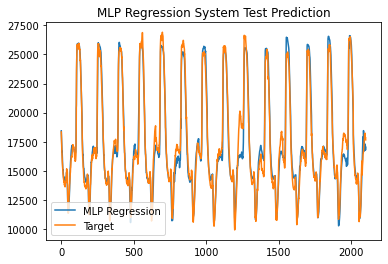

In [32]:
for i, (estimator, y_train, y_test) in enumerate(zip(best_models_mlp, y_trains, y_tests)):
    model_params = estimator.get_params()
    model = MLPRegressor(solver=model_params['solver'], momentum=model_params['momentum'], nesterovs_momentum=model_params['nesterovs_momentum'],
                            learning_rate=model_params['learning_rate'], learning_rate_init=model_params['learning_rate_init'],
                            hidden_layer_sizes=model_params['hidden_layer_sizes'], alpha=model_params['alpha'], early_stopping=model_params['early_stopping'],
                            max_iter=model_params['max_iter'], batch_size=model_params['batch_size'])
    model.fit(X_train, y_train)

    r_squared_best_mlp_train = model.score(X_train, y_train)
    unscaled_mlp_train_rmse = get_unscaled_rmse(model.predict(X_train), scaler, i)
    r_squared_best_mlp_test = model.score(X_test, y_test)
    unscaled_mlp_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(model.predict(X_test), scaler, i, test=True)

    print(f'The best MLP Regression system results in an r-squared value of: {r_squared_best_mlp_train} and an RMSE value of: {unscaled_mlp_train_rmse} for Zone {i+1} during the training phase')
    print(f'The best MLP Regression system results in an r-squared value of: {r_squared_best_mlp_test} and an RMSE value of: {unscaled_mlp_test_rmse} for Zone {i+1} during the testing phase')

    plt.plot(range(int(np.size(y_true_test)/5)), y_pred_unscaled[:int(np.size(y_true_test)/5)])
    plt.plot(range(int(np.size(y_true_test)/5)), y_true_test[:int(np.size(y_true_test)/5)])
    plt.legend(['MLP Regression', 'Target'])
    plt.title('MLP Regression System Test Prediction')
    plt.show()

# Extra, Non - EE 559 Methods

# Random Forest Regressor

The Random Forest system results in an r-squared value of 0.9982822892949352 and an RMSE value of: 294.0093678966878 for Zone 1 during the training phase
The Random Forest system results in an r-squared value of 0.9369074314808523 and an RMSE value of: 1827.1663285245422 for Zone 1 during the testing phase


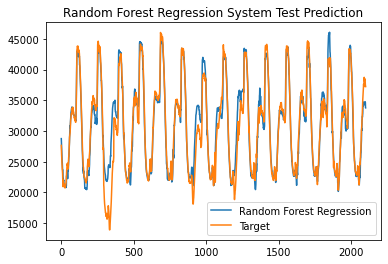

The Random Forest system results in an r-squared value of 0.9981186231153603 and an RMSE value of: 224.41620637124126 for Zone 2 during the training phase
The Random Forest system results in an r-squared value of 0.9031825913622834 and an RMSE value of: 1651.0321313902698 for Zone 2 during the testing phase


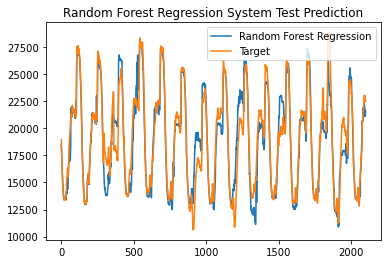

The Random Forest system results in an r-squared value of 0.9993903014223977 and an RMSE value of: 161.79713167732422 for Zone 3 during the training phase
The Random Forest system results in an r-squared value of 0.9704223161259433 and an RMSE value of: 1184.9309445133933 for Zone 3 during the testing phase


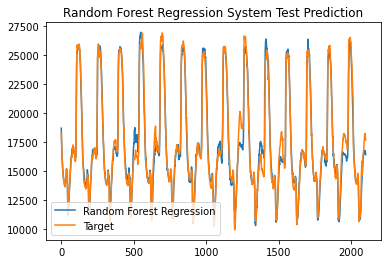

In [34]:
for i, (y_train, y_test) in enumerate(zip(y_trains, y_tests)):
    rf = RandomForestRegressor().fit(X_train, y_train)
    r_squared_rf_train = rf.score(X_train, y_train)
    unscaled_rf_train_rmse = get_unscaled_rmse(rf.predict(X_train), scaler, i)

    r_squared_rf_test = rf.score(X_test, y_test)
    unscaled_rf_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(rf.predict(X_test), scaler, i, test=True)

    print(f'The Random Forest system results in an r-squared value of {r_squared_rf_train} and an RMSE value of: {unscaled_rf_train_rmse} for Zone {i+1} during the training phase')
    print(f'The Random Forest system results in an r-squared value of {r_squared_rf_test} and an RMSE value of: {unscaled_rf_test_rmse} for Zone {i+1} during the testing phase')

    plt.plot(range(int(np.size(y_true_test)/5)), y_pred_unscaled[:int(np.size(y_true_test)/5)])
    plt.plot(range(int(np.size(y_true_test)/5)), y_true_test[:int(np.size(y_true_test)/5)])
    plt.legend(['Random Forest Regression', 'Target'])
    plt.title('Random Forest Regression System Test Prediction')
    plt.show()

# XGBoost

The XGBoost system results in an r-squared value of 0.9879155919374801 and an RMSE value of: 779.8280423796305 for Zone 1 during the training phase
The XGBoost system results in an r-squared value of 0.9405449389083862 and an RMSE value of: 1773.7131841555677 for Zone 1 during the testing phase


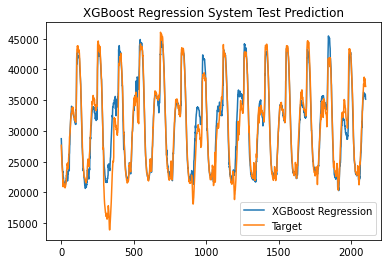

The XGBoost system results in an r-squared value of 0.9864354321567198 and an RMSE value of: 602.5863583935492 for Zone 2 during the training phase
The XGBoost system results in an r-squared value of 0.9148433706133274 and an RMSE value of: 1548.4173527552023 for Zone 2 during the testing phase


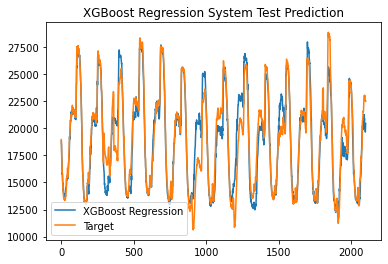

The XGBoost system results in an r-squared value of 0.994737634959158 and an RMSE value of: 475.33928963272245 for Zone 3 during the training phase
The XGBoost system results in an r-squared value of 0.9779164680278235 and an RMSE value of: 1023.8709639118396 for Zone 3 during the testing phase


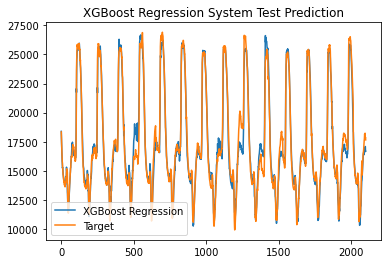

In [35]:
for i, (y_train, y_test) in enumerate(zip(y_trains, y_tests)):
    xgb = XGBRegressor().fit(X_train, y_train)
    r_squared_xgb_train = xgb.score(X_train, y_train)
    unscaled_xgb_train_rmse = get_unscaled_rmse(xgb.predict(X_train), scaler, i)

    r_squared_xgb_test = xgb.score(X_test, y_test)
    unscaled_xgb_test_rmse, y_true_test, y_pred_unscaled = get_unscaled_rmse(xgb.predict(X_test), scaler, i, test=True)

    print(f'The XGBoost system results in an r-squared value of {r_squared_xgb_train} and an RMSE value of: {unscaled_xgb_train_rmse} for Zone {i+1} during the training phase')
    print(f'The XGBoost system results in an r-squared value of {r_squared_xgb_test} and an RMSE value of: {unscaled_xgb_test_rmse} for Zone {i+1} during the testing phase')

    plt.plot(range(int(np.size(y_true_test)/5)), y_pred_unscaled[:int(np.size(y_true_test)/5)])
    plt.plot(range(int(np.size(y_true_test)/5)), y_true_test[:int(np.size(y_true_test)/5)])
    plt.legend(['XGBoost Regression', 'Target'])
    plt.title('XGBoost Regression System Test Prediction')
    plt.show()